In [ ]:
from pprint import pprint
import numpy as np
import re
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd

# The on_bad_lines='skip' will ignore the problematic rows.
profiles = pd.read_csv('/content/okcupid_profiles.csv', engine='python', on_bad_lines='skip')

# Check the info to see how many rows were loaded successfully
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1760 non-null   int64  
 1   status       1760 non-null   object 
 2   sex          1760 non-null   object 
 3   orientation  1760 non-null   object 
 4   body_type    1619 non-null   object 
 5   diet         1080 non-null   object 
 6   drinks       1668 non-null   object 
 7   drugs        1320 non-null   object 
 8   education    1576 non-null   object 
 9   ethnicity    1582 non-null   object 
 10  height       1760 non-null   float64
 11  income       1760 non-null   int64  
 12  job          1510 non-null   object 
 13  last_online  1760 non-null   object 
 14  location     1760 non-null   object 
 15  offspring    757 non-null    object 
 16  pets         1194 non-null   object 
 17  religion     1145 non-null   object 
 18  sign         1447 non-null   object 
 19  smokes

In [ ]:
df = profiles.copy()

In [ ]:
df.height = df.height.apply(lambda x: round(x * 2.54, 0))


In [ ]:
df.describe()


,age,height,income
count,1760.000000,1760.000000,1760.000000
mean,32.207955,174.196591,23527.604545
std,8.955892,9.587868,108357.564063
min,18.000000,147.000000,-1.000000
25%,26.000000,168.000000,-1.000000
50%,30.000000,175.000000,-1.000000
75%,37.000000,180.000000,-1.000000
max,68.000000,231.000000,1000000.000000


In [ ]:
mask = df.height.isna()
df.loc[mask,'height'] = df.height.median()
df.loc[df.income == -1, 'income'] = np.nan
print(f'People that do not declare income: {df.income.isna().sum()/len(df):0.0%}')

People that do not declare income: 80%


In [ ]:
df.loc[df.income == -1, 'income'] = np.nan

In [ ]:
print(f'People that do not declare income: {df.income.isna().sum()/len(df):0.0%}')

People that do not declare income: 80%


In [ ]:
isna_cols = df.loc[:,df.isna().any()].columns
missing_values = df[isna_cols[:12]].isna().sum().sort_values(ascending=False)

/tmp/ipython-input-958802312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index,y=missing_values,palette='dark')


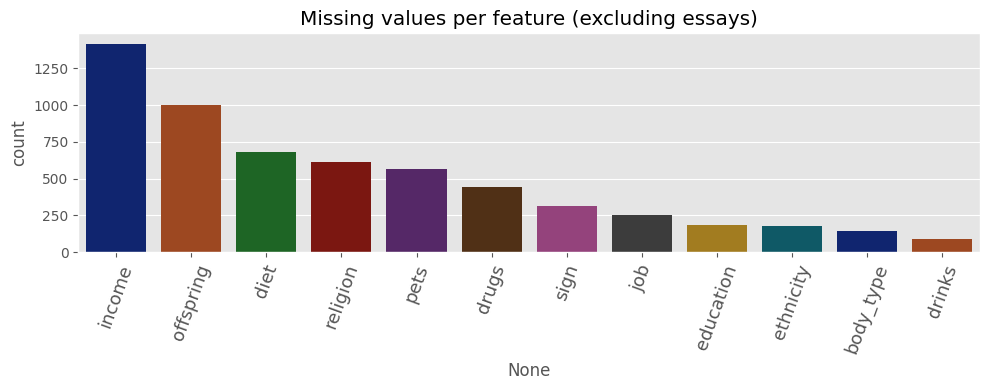

In [ ]:
plt.style.use('ggplot')
fig0, ax0 = plt.subplots(figsize=(10,4))
sns.barplot(x=missing_values.index,y=missing_values,palette='dark')
ax0.set(xticks=range(len(missing_values)),title='Missing values per feature (excluding essays)', ylabel = 'count')
ax0.set_xticklabels(labels=missing_values.index, rotation=70,fontsize=13)
ax0.annotate('81% of users do not declare income', xy = (0.4, 48000),
             xytext=(2,41000),fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05));
fig0.tight_layout()
fig0.savefig('figure_00.png')

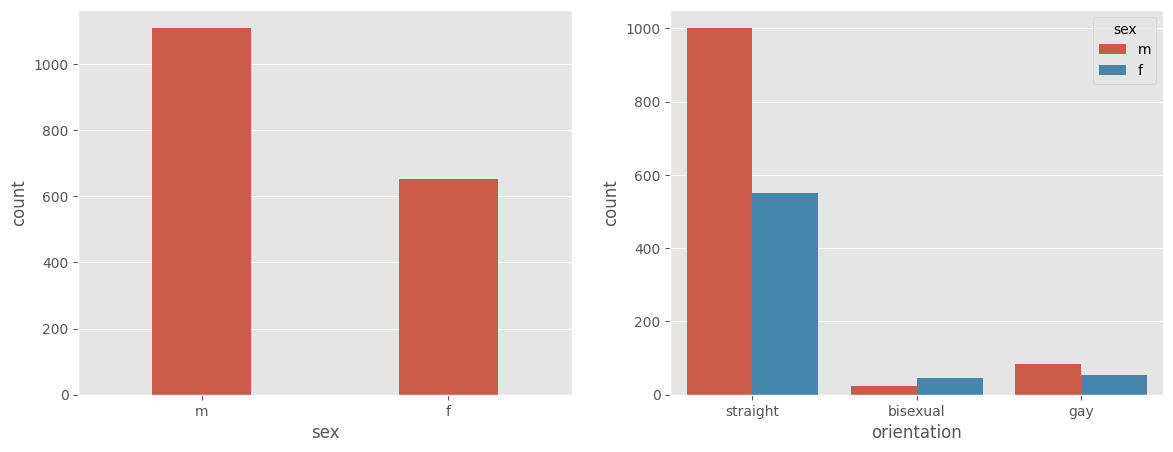

In [ ]:
fig1, ax1 = plt.subplots(ncols=2,figsize=(14, 5))
cat_cols = ['sex', 'orientation']
titles = ['Sex distribution', 'Sexual orientation']

sns.countplot(data=df, x='sex', ax=ax1[0], width=0.4)
sns.countplot(data=df, x='orientation', hue='sex', ax=ax1[1])
fig1.savefig('figure_01.png');

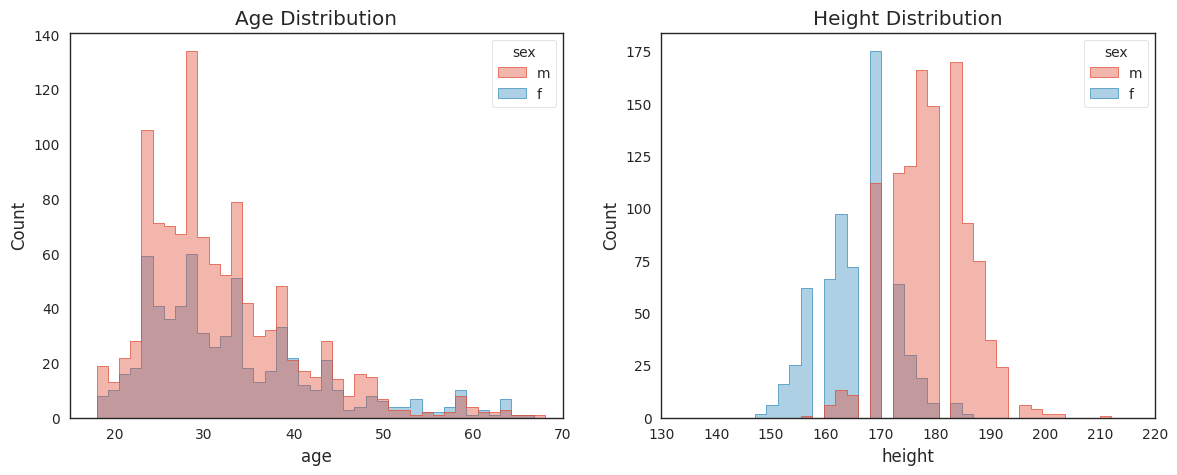

In [ ]:
sns.set_style("white")
num_cols = ['age','height']
xlims = [(15, 70), (130,220)]
titles = ['Age Distribution', 'Height Distribution']
fig2, ax2 = plt.subplots(ncols=2, figsize=(14,5),sharey=False)
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=ax2[i], hue='sex', element='step',bins=40, alpha=0.4)
    ax2[i].set(xlim=xlims[i], title = titles[i])
fig2.savefig('figure_02.png')

In [ ]:
df[['city_','state_']] = df.location.str.split(pat=', ',expand=True).loc[:,0:1]
df.loc[:,['location', 'city_', 'state_']]
df.state_.value_counts(normalize=True).round(4)[:5]*100

,proportion
state_,
california,99.94
colorado,0.06


In [ ]:
city_count = df.city_.value_counts(normalize=True).round(3)[:20]*100

/tmp/ipython-input-1213178527.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_count.index, y=city_count, palette='dark', ax=ax3)


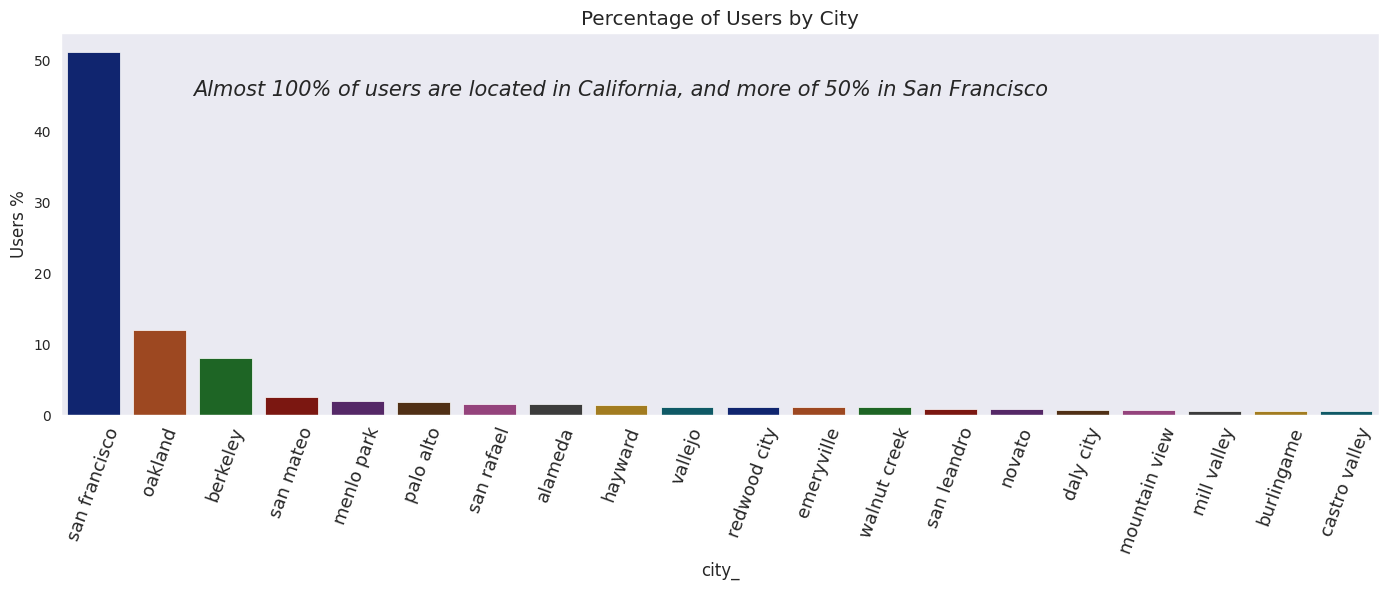

In [ ]:
sns.set_style("dark")
fig3, ax3 = plt.subplots(figsize=(14,6))
sns.barplot(x=city_count.index, y=city_count, palette='dark', ax=ax3)
ax3.set(xticks=range(len(city_count)),title='Percentage of Users by City',ylabel = 'Users %')
ax3.set_xticklabels(labels=city_count.index, rotation=70,fontsize=13)
ax3.text(1.5, 45, 'Almost 100% of users are located in California, and more of 50% in San Francisco',
         style='italic', fontsize=15);
fig3.tight_layout()
fig3.savefig('figure_03.png')

In [ ]:
def map_cat(a_string, a_dic):
    ''' a_string: a string we want to map with a_dic
        a_dic: a dictionary whose keys are tuples'''
    for k in a_dic:
        if a_string in k:
            return a_dic.get(k)
    return np.nan

In [ ]:
df.body_type.value_counts(dropna=False)

,count
body_type,
fit,409
average,403
athletic,375
thin,158
NaN,141
curvy,94
a little extra,79
skinny,51
full figured,24


In [ ]:
body_types_dic={('skinny','used up','thin'):'ectomorph',
               ('average','fit','athletic','jacked'):'mesomorph',
               ('a little extra','curvy','full figured'):'endomorph'}

body_categories = CategoricalDtype(categories=['ectomorph','mesomorph','endomorph'], ordered=True)

df['body_type_'] = df.body_type.apply(map_cat,args=(body_types_dic,)).astype(body_categories)
df.body_type_ = df.body_type_.fillna(body_categories.categories[int(np.median(df.body_type_.cat.codes))])

In [ ]:
education_categories = CategoricalDtype(categories=['High school or less','Some college',
                                        'College or more','Post graduate degree'],
                                        ordered=True)

In [ ]:
education_dic= {('graduated from high school','dropped out of high school',
                 'working on high school','high school'): 'High school or less',

                ('working on two-year college','dropped out of space camp',
                'two-year college', 'graduated from two-year college',
                'dropped out of college/university','dropped out of two-year college',
                 'dropped out of med school', 'dropped out of law school'): 'Some college',

                ('working on college/university', 'working on space camp',
                'graduated from masters program','graduated from college/university',
                'working on masters program','graduated from space camp',
                'college/university','graduated from law school',
                 'working on ph.d program','space camp',
                 'graduated from med school','working on med school',
                'masters program', 'dropped out of ph.d program',
                'law school','dropped out of masters program',
                'working on law school', 'med school') : 'College or more',

                ('graduated from ph.d program','ph.d program'): 'Post graduate degree'}


In [ ]:
df['education_'] = df.education.apply(map_cat,args=(education_dic,)).astype(education_categories)

In [ ]:
df.education_ = df.education_.fillna(education_categories.\
                                    categories[int(np.median(df['education_'].cat.codes))]).\
                                    astype(education_categories)

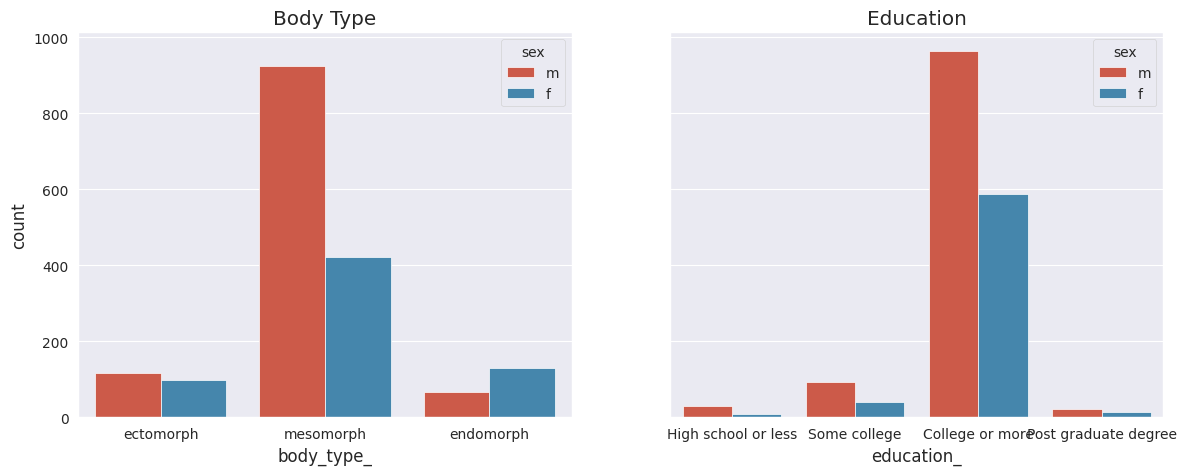

In [ ]:
sns.set_style("darkgrid")
cat_cols = ['body_type_','education_']
titles = ['Body Type', 'Education']
fig4, ax4 = plt.subplots(ncols=2, figsize=(14,5),sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax4[i], hue='sex')
    ax4[i].set(title = titles[i])
fig4.savefig('figure_04.png')

In [ ]:
drinks_categories = CategoricalDtype(categories=['not at all','rarely','socially',
                                                 'often','very often','desperately'],
                                     ordered=True)
df['drinks_'] = df.drinks.astype(drinks_categories)
df.drinks_ = df.drinks_.fillna(drinks_categories.categories[int(np.median(df.drinks_.cat.codes))])

In [ ]:
df.drugs.value_counts(dropna=False)

,count
drugs,
never,1077
NaN,440
sometimes,233
often,10


In [ ]:
df['drugs_'] = df.drugs.fillna('never')
df.drugs_.value_counts(dropna=False)
df.drugs_ = pd.Categorical(df.drugs_, categories=['never', 'sometimes','often'], ordered=True)

In [ ]:
df.smokes.value_counts(dropna=False)

,count
smokes,
no,1313
NaN,168
when drinking,101
sometimes,85
trying to quit,51
yes,42


In [ ]:
smokes_dic = {('no',):'no',
             ('sometimes', 'when drinking', 'trying to quit'):'sometimes',
              ('yes',):'yes'}
smokes_categories = CategoricalDtype(categories=['no', 'sometimes', 'yes'],ordered=True)
df['smokes_'] = df.smokes.apply(map_cat, args=(smokes_dic,)).astype(smokes_categories)
df.smokes_ = df.smokes_.fillna('no').astype(smokes_categories)
df.smokes_.value_counts(dropna=False).sort_index()

,count
smokes_,
no,1481
sometimes,237
yes,42


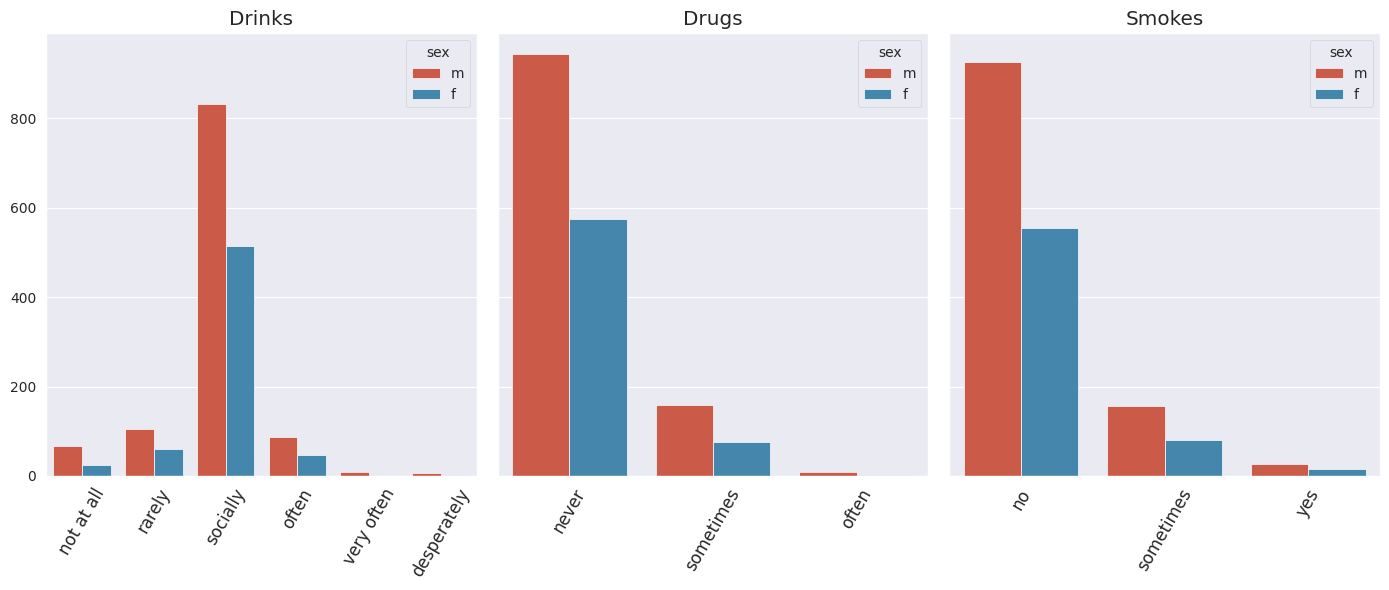

In [ ]:
sns.set_style("darkgrid")
cat_cols = ['drinks_', 'drugs_', 'smokes_']
titles = ['Drinks', 'Drugs', 'Smokes']
xlabels = [ list(drinks_categories.categories), ['never', 'sometimes','often'], list(smokes_categories.categories) ]
ticks = [6, 3, 3]
fig5, ax5 = plt.subplots(ncols=3, figsize=(14,6),sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax5[i], hue='sex')
    ax5[i].set(title = titles[i], xticks = range(len(xlabels[i])) ,xlabel='', ylabel='')
    ax5[i].set_xticklabels(labels = xlabels[i], rotation=60,fontsize=12)
fig5.tight_layout()
fig5.savefig('figure_05.png')

In [ ]:
df.pets.value_counts(dropna=False)

,count
pets,
NaN,566
likes dogs and likes cats,452
likes dogs,210
has dogs,134
likes dogs and has cats,119
has dogs and likes cats,69
likes dogs and dislikes cats,55
has cats,45
has dogs and has cats,42


In [ ]:
df.pets = df.pets.fillna('No')

In [ ]:
def likes_pet(s, species):
    dogs_regex = re.compile(r'((?<!dis)likes |has )dogs')
    cats_regex = re.compile(r'((?<!dis)likes |has )cats')
    if species == 'dog':
        return 'Yes' if bool(dogs_regex.search(s)) else 'No'
    elif species == 'cat':
        return 'Yes' if bool(cats_regex.search(s)) else 'No'
    else:
        return 'No'

In [ ]:
df['likes_dogs_'] = df.pets.apply(likes_pet,args = ('dog',))
df['likes_cats_'] = df.pets.apply(likes_pet,args = ('cat',))
df['likes_dogs_'] = pd.Categorical(df.likes_dogs_,categories=['No', 'Yes'],ordered=True)
df['likes_cats_'] = pd.Categorical(df.likes_cats_,categories=['No', 'Yes'],ordered=True)

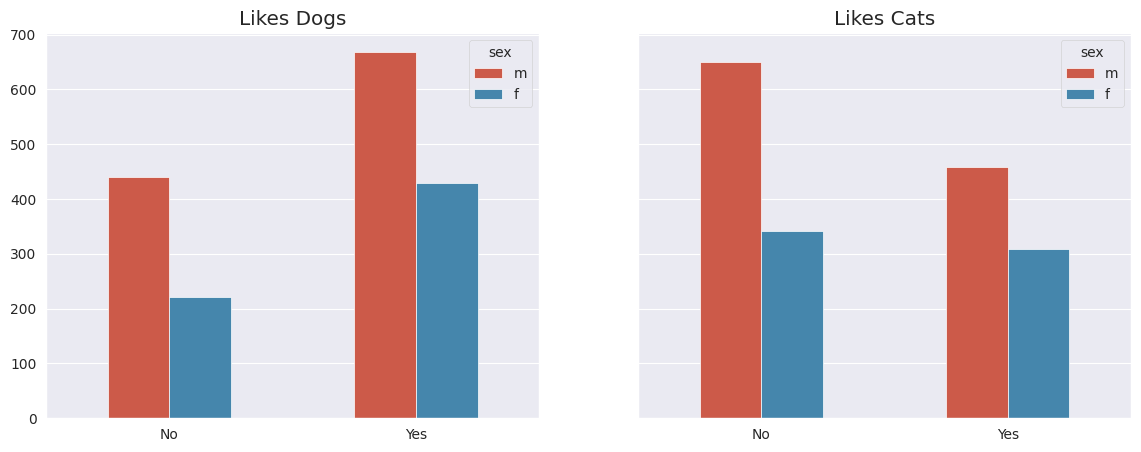

In [ ]:
sns.set_style("darkgrid")
cat_cols = ['likes_dogs_', 'likes_cats_']
titles=['Likes Dogs', 'Likes Cats']
fig6, ax6 = plt.subplots(ncols=2, figsize=(14,5),sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax6[i], hue='sex', width=0.5)
    ax6[i].set(title = titles[i],xlabel='', ylabel='')
fig6.savefig('figure_06.png')

In [ ]:
features = ['age', 'height', 'body_type_', 'education_', 'drinks_', 'drugs_', 'smokes_', 'likes_dogs_', 'likes_cats_']

In [ ]:
X = df[features[0:2]].copy()
X.head()

,age,height
0,22,190.0
1,35,178.0
2,38,173.0
3,23,180.0
4,29,168.0


In [ ]:
for feat in features[2:]:
    X[feat] = df[feat].cat.codes

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform='pandas')

X_scaled = scaler.fit_transform(X)

In [ ]:
num_clusters=list(np.arange(1, 21))

inertias = []

for k in num_clusters:
  model = KMeans(n_clusters = k, n_init='auto')
  model.fit(X_scaled)
  inertias.append(model.inertia_)

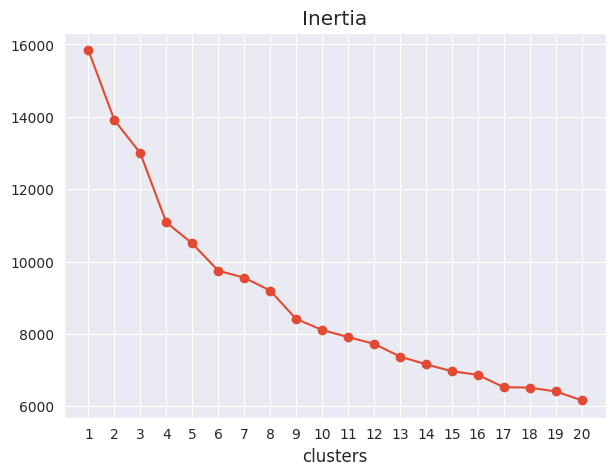

In [ ]:
fig7, ax7 = plt.subplots(figsize=(7, 5))

ax7.plot(num_clusters, inertias, '-o')
ax7.set(xticks=num_clusters, xlabel='clusters', title='Inertia')
fig7.savefig('figure_07.png')

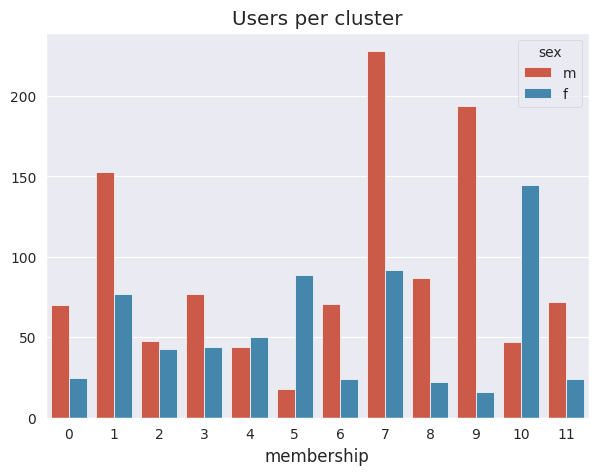

In [ ]:
k = 12
model = KMeans(n_clusters = k, n_init='auto')
model.fit(X_scaled)
df['membership'] = model.labels_
df.membership.value_counts()

fig8, ax8 = plt.subplots(figsize=(7, 5))

sns.countplot(data=df, x='membership', ax=ax8, hue='sex')
ax8.set(title = 'Users per cluster', ylabel='');
fig8.savefig('figure_08.png')

In [ ]:
features = ['age', 'height', 'sex', 'orientation', 'sex', 'orientation', 'body_type_',
 'education_', 'drinks_', 'drugs_', 'smokes_', 'likes_dogs_', 'likes_cats_',
 'membership']

In [ ]:
df.loc[42:42,features]

,age,height,sex,orientation,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
42,30,190.0,m,straight,m,straight,mesomorph,College or more,often,sometimes,no,No,No,6


In [ ]:
users = df.loc[(df.sex == 'f') &
               (df.membership == df.at[42, 'membership']) &
               (df.orientation == 'straight')].index
print(f'And so we have found {len(users)} female users in the same cluster.\n ')

And so we have found 16 female users in the same cluster.
 


In [ ]:
def distance(row, user):
    result = 0
    for i, v in enumerate(row):
        result += (v - user[i])**2
    return result ** 0.5;
user = X_scaled.loc[42]


In [ ]:
distances = X_scaled.loc[users].apply(distance, axis = 1, args=(user,) ).sort_values();

/tmp/ipython-input-3847456109.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result += (v - user[i])**2


In [ ]:

df.loc[924:924, features]

,age,height,sex,orientation,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
924,24,165.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,No,No,6


In [ ]:
df.loc[distances.index, features].head(10)

,age,height,sex,orientation,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
924,24,165.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,No,No,6
1538,26,170.0,f,straight,f,straight,mesomorph,College or more,often,sometimes,sometimes,No,No,6
975,23,165.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,No,No,6
1188,23,165.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,No,No,6
208,34,170.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,No,Yes,6
1052,26,163.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,Yes,No,6
966,25,170.0,f,straight,f,straight,mesomorph,Some college,often,sometimes,sometimes,No,No,6
98,31,168.0,f,straight,f,straight,endomorph,College or more,socially,sometimes,no,Yes,No,6
92,29,170.0,f,straight,f,straight,endomorph,Some college,socially,sometimes,no,No,No,6
626,39,160.0,f,straight,f,straight,mesomorph,College or more,socially,sometimes,no,Yes,No,6


In [ ]:
gamma = 1 /(len(features))

In [ ]:
S = pd.DataFrame(distances.apply(lambda x: round(np.exp(-x * gamma)*100,1)).rename('affinity'))
S.rename_axis('user_id', inplace=True)
print('Top ten users by affinity with user_id = 42')
S.head(10)

Top ten users by affinity with user_id = 42


,affinity
user_id,
924,80.2
1538,80.1
975,80.1
1188,80.1
208,79.0
1052,76.1
966,75.4
98,75.1
92,74.7
